### Preparing data

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Directory in which we have saved the data
data_directory = ""

# Read data
X_df = pd.read_csv(data_directory+"BASC197_X_corr.csv")
X = X_df.to_numpy()

Y_df = pd.read_csv(data_directory+"Y.csv")
Y = Y_df.to_numpy()
Y = Y.ravel() # class 0 for control and class 1 for autism

In [285]:
print(f"Total number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Samples of ASD: {X[Y==1].shape[0]}")
print(f"Samples of TD: {X[Y==0].shape[0]}")

Total number of samples: 870
Number of features: 19503
Samples of ASD: 402
Samples of TD: 468


### **Cross-validation**


In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score


In [4]:
def cross_validation_func(model, param_grid, X, Y, masks, cv_outer):
    """
    Performs nested cross validation, finding the best hyperparameters for the model
    in each split with GridSearchCV and saving the corresponding metrics

    Parameters:
    model: sklearn model
    param_grid: dicionary with hyperparameters names as keys with their possible values
    X,Y: numpy.array data
    masks: list of arrays of booleans with the same shape, indicating the features to be used
    cv_outer: sklearn StratifiedKfold split for cross validation

    Returns:
    scores (dict): dictionary with metrics as keys, 
    and their values are lists with the performance of the model for each cv split
    """

    # Define the lists in which we will save the corresponding metrics and scores
    scores = dict()
    recall = []
    precision = []
    accuracy = []
    roc_auc = []
    best_params = []

    # Define cv splits
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
    
    i = 0

    # Complete steps
    for train_index, test_index in cv_outer.split(X, Y):
        
        X_train, X_test = X[train_index][:, masks[i]], X[test_index][:, masks[i]]

        Y_train, Y_test = Y[train_index], Y[test_index]

        # Define search
        search = GridSearchCV(model, param_grid=param_grid, scoring='accuracy', cv=cv_inner, refit=True, verbose=10)

        search.fit(X_train, Y_train)

        Y_pred = search.predict(X_test)

        roc_auc.append(roc_auc_score(Y_test,Y_pred))
        accuracy.append(accuracy_score(Y_test, Y_pred))
        recall.append(recall_score(Y_test,Y_pred))
        precision.append(precision_score(Y_test,Y_pred,average='weighted'))
        best_params.append(search.best_params_)
        
        i+=1

    scores["roc_auc"] = roc_auc
    scores["accuracy"] = accuracy
    scores["recall"] = recall
    scores["precision"] = precision
    scores["best_params"] = best_params

    return scores

In [5]:
def feature_selection(X, Y, cv_outer): 
    """
    Selects the best features of the given data for each cross validation split:
    firstly, it calculates the top features with the best ANOVA F-score, and afterwards, 
    it performs Recursive Feature Elimination with a linear SVM model

    Parameters:
    X,Y: numpy.array data
    cv_outer: sklearn StratifiedKfold split for cross validation

    Returns:
    masks: list of arrays of booleans with the same shape (and the same dimension as the number of features of X), 
    indicating the most important features
    """

    masks = list()

    # Pre-established parameters 
    anova_k = 5000
    step_features = 20

    # Selects the best features for each split
    for train_index, test_index in cv_outer.split(X, Y):
        X_train = X[train_index]
        Y_train = Y[train_index]

        # Selecting features with the best ANOVA F-score
        anova = SelectKBest(score_func=f_classif, k=anova_k)
        X_train = anova.fit_transform(X_train,Y_train)

        # Mask for ANOVA
        mask_anova = anova.get_support()

        # Performs RFE with linear SVM
        rfe = RFECV(estimator=SVC(kernel="linear",C=1), cv=cv_outer, step=step_features, verbose=True)
        rfe.fit(X_train, Y_train)

        # Mask for RFE
        mask_rfe = rfe.support_
        
        # Combinig the generated masks 
        mask_pad = np.pad(mask_rfe, (0, len(mask_anova) - len(mask_rfe)), constant_values=False)
        combined_mask = np.logical_and(mask_anova, mask_pad)

        masks.append(combined_mask)

    return masks



### **Models**

In [230]:
# Outer split for nested cross validation (same for feature selection and CV training)
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Features' masks (onñy for SVM, LR and XGBoost) for each split
masks = feature_selection(X=X, Y=Y, cv_outer=cv_outer)

In [208]:
# Save masks
masks_df = pd.DataFrame(masks)
masks_df.to_csv("./results/masks_results.csv", index=False)

In [216]:
masks = np.array(pd.read_csv("./results/masks_results.csv"))

In [138]:
# Note that we achieved that the number of features for every split is lower than the total samples
for i in range(5):
    print(f"Number of features for CV split {i}: {masks[i].sum()}")

Number of features for CV split 0: 392
Number of features for CV split 1: 122
Number of features for CV split 2: 671
Number of features for CV split 3: 200
Number of features for CV split 4: 252


#### SVM model

In [ ]:
# Parameters' grid for SVM model 
param_grid_svm = {
    'degree': [3,4,5], 
    'kernel': ['rbf', 'poly', 'sigmoid'], 
    'gamma': [1, 0.1, 0.01, 1e-3, 1e-4, 1e-5],
    'C': [0.1, 1, 10, 100, 1000, 10000]}

# Define SVM model
model_svm = SVC(probability=True, random_state=42, max_iter=-1)

# Train model and get scores
scores_svm = cross_validation_func(model_svm, param_grid=param_grid_svm, X=X, Y=Y, masks=masks, cv_outer=cv_outer)

In [229]:
# Save results
scores_svm_df = pd.DataFrame(scores_svm)
scores_svm_df.to_csv("./results/svm_results.csv", index=False)

#### Logistic Regression

In [219]:
# Parameters grid for Logistic Regression model
param_grid_lr ={
    "C":[0.01, 0.1, 10, 100, 1000], 
    "penalty":["l1","l2"]}

# Define model (saga solver for big datasets)
model_lr = LogisticRegression(random_state=42, solver="saga", max_iter=10000)

# Train model and get scores
scores_lr = cross_validation_func(model_lr, param_grid_lr, X, Y, masks=masks, cv_outer=cv_outer)


In [222]:
# Save results
scores_lr_df = pd.DataFrame(scores_lr)
scores_lr_df.to_csv("./results/lr_results.csv", index=False)

#### XGBoost

In [223]:
# Parameters grid for XGBoost model
param_grid_xgb = {
            "min_child_weight": [1, 5, 10],
            "gamma": [0.5, 1, 1.5, 2, 5],
            "subsample": [0.6, 0.8, 1.0],
            "colsample_bytree": [0.6, 0.8, 1.0],
            "max_depth": [3, 4, 5]
        }

# Define model
model_xgb = XGBClassifier(random_state=42)

In [ ]:
# Train model and get scores 
scores_xgb = cross_validation_func(model_xgb, param_grid_xgb, X=X, Y=Y, masks=masks, cv_outer=cv_outer)

In [225]:
# Save results
scores_xgb_df = pd.DataFrame(scores_xgb)
scores_xgb_df.to_csv("./results/xgb_results.csv", index=False)

#### ASD-DiagNet

In [217]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, TransformerMixin

In [218]:
def feature_selection_diagnet(matrix):
    """
    Given a matrix m x n , sums all the rows, calculates the 25% and 75% percentiles,
    and returns a mask (with n dimensions) with True in those positions
    """

    # Sum rows
    row_sums = np.sum(matrix, axis=0)
    
    # Higher and lower values
    q1 = np.percentile(row_sums, 25)
    q3 = np.percentile(row_sums, 75)
    
    # Create mask
    mask = (row_sums <= q1) | (row_sums >= q3)
    
    return mask

In [236]:
# Create mask
mask_diagnet = feature_selection_diagnet(X)

In [237]:
print(f"Total number of features for ASD-DiagNet: {mask_diagnet.sum()}")

Total number of features for ASD-DiagNet: 9752


In [219]:
# ASD-DiagNet Model
# Combining an autoencoder and a single-layer perceptron
# (Note: part of the following code was extracted from https://github.com/pcdslab/ASD-DiagNet/tree/master)


# Creating an AutoEncoder with Torch

class MTAutoEncoder(nn.Module):
    def __init__(self, num_inputs=990, num_latent=200, tied=True, use_dropout=False):
        super(MTAutoEncoder, self).__init__()
        self.tied = tied
        self.num_latent = num_latent
        
        self.fc_encoder = nn.Linear(num_inputs, num_latent)
    
        if not tied:
            self.fc_decoder = nn.Linear(num_latent, num_inputs)
        
        if use_dropout:
            self.classifier = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Linear(self.num_latent, 1), 
            )
        else:
            self.classifier = nn.Sequential(
                nn.Linear(self.num_latent, 1),  
            )
            
    def forward(self, x, eval_classifier=False):
        x = self.fc_encoder(x)
        x = torch.tanh(x)
        if eval_classifier:
            x_logit = self.classifier(x)
        else:
            x_logit = None
        
        if self.tied:
            x = torch.nn.functional.linear(x, self.fc_encoder.weight.t())
        else:
            x = self.fc_decoder(x)
            
        return x, x_logit



# Creating a estimator class of the AutoEncoder with a single-layer perceptron, so that we can use it with sklearn

class AutoEncoderEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, num_inputs=990, num_latent=200, tied=True, use_dropout=False, lr=0.001, epochs=10, batch_size=32):
        self.num_inputs = num_inputs
        self.num_latent = num_latent
        self.tied = tied
        self.use_dropout = use_dropout
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.model = MTAutoEncoder(num_inputs, num_latent, tied, use_dropout=use_dropout).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss(reduction='sum')
        self.classification_criterion = nn.BCEWithLogitsLoss()  
        
        
    def fit(self, X, y=None):
        self.model.train()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        if y is not None:
            y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(self.device)  
            dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        else:
            dataset = torch.utils.data.TensorDataset(X_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        for epoch in range(self.epochs):

            for data in dataloader:
                if y is not None:
                    inputs, labels = data
                else:
                    inputs = data[0]
                    labels = None
                    
                self.optimizer.zero_grad()
                outputs, logits = self.model(inputs, eval_classifier=y is not None)
                if labels is not None:
                    loss = self.criterion(outputs, inputs) + self.classification_criterion(logits, labels)
                else:
                    loss = self.criterion(outputs, inputs)
                loss.backward()
                self.optimizer.step()
        
        return self
    

    def transform(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)

        with torch.no_grad():
            encoded, _ = self.model(X_tensor)

        return encoded.cpu().numpy()
    

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            _, logits = self.model(X_tensor, eval_classifier=True)

        return torch.sigmoid(logits).cpu().numpy()

In [224]:
# Cross-validation function only for ASD-DiagNet model
def cross_validation_func_diagnet(X, Y, cv_outer, mask):
    """
    It performs cross validation for the given outer split (without using GrisSearchCV for better hyperparameters
    in order to replicate the original ASD-DiagNet model), evaluates the model on different metrics and returns 
    the scores for each split

    Parameters:
    X,Y: numpy.array data
    cv_outer: sklearn StratifiedKfold split for cross validation

    Returns:
    mask: numpy array of booleans, indicating the selected features for training
    """

    scores = dict()
    recall = []
    precision = []
    accuracy = []
    roc_auc = []

    # Train the model for each split and compute scores
    for train_index, test_index in cv_outer.split(X, Y):
        
        X_train, X_test = X[train_index][:,mask], X[test_index][:,mask]

        Y_train, Y_test = Y[train_index], Y[test_index]

        # Define search
        # The number of latent features was the same as the original paper, as well as the learning rate (lr), epochs and batch size
        model = AutoEncoderEstimator(num_inputs=mask.sum(), num_latent=200, epochs=25, lr=0.0001, batch_size=64)
        model.fit(X_train, Y_train)
        encoded_test = model.transform(X_test)

        Y_pred = model.predict(encoded_test)

        Y_pred = (Y_pred > 0.5).astype(int)

        roc_auc.append(roc_auc_score(Y_test,Y_pred))
        accuracy.append(accuracy_score(Y_test, Y_pred))
        recall.append(recall_score(Y_test,Y_pred))
        precision.append(precision_score(Y_test,Y_pred,average="weighted"))

    scores["roc_auc"] = roc_auc
    scores["accuracy"] = accuracy
    scores["recall"] = recall
    scores["precision"] = precision
    
    return scores

In [148]:
# Train the ASD-DiagNet model and get scores
scores_diagnet = cross_validation_func_diagnet(X=X, Y=Y, cv_outer=cv_outer, mask=mask_diagnet)

In [149]:
# Save results
scores_diagnet_df = pd.DataFrame(scores_diagnet)
scores_diagnet_df.to_csv("./results/diagnet_results.csv")

### **Analysis**


#### Best model

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [238]:
# Creating DataFrames for the results of each model
scores_svm_df = pd.read_csv("./results/svm_results.csv")
scores_lr_df = pd.read_csv("./results/lr_results.csv")
scores_xgb_df = pd.read_csv("./results/xgb_results.csv")
scores_diagnet_df = pd.read_csv("./results/diagnet_results.csv")

In [258]:
# Create a summary DataFrame

svm_mean = scores_svm_df[["roc_auc", "precision", "recall", "accuracy"]].mean().round(4)
lr_mean = scores_lr_df[["roc_auc", "precision", "recall", "accuracy"]].mean().round(4)
xgb_mean = scores_xgb_df[["roc_auc", "precision", "recall", "accuracy"]].mean().round(4)
diagnet_mean = scores_diagnet_df[["roc_auc", "precision", "recall", "accuracy"]].mean().round(4)

summary_df = pd.DataFrame({
    'Model': ['ASD-DiagNet', 'SVM', 'Logistic Regression', 'XGBoost'],
    'Accuracy': [diagnet_mean['accuracy'], svm_mean['accuracy'], lr_mean['accuracy'], xgb_mean['accuracy']],
    'Precision': [diagnet_mean['precision'], svm_mean['precision'], lr_mean['precision'], xgb_mean['precision']],
    'Recall': [diagnet_mean['recall'], svm_mean['recall'], lr_mean['recall'], xgb_mean['recall']],
    'ROC AUC': [diagnet_mean['roc_auc'], svm_mean['roc_auc'], lr_mean['roc_auc'], xgb_mean['roc_auc']]
    
})

In [264]:
# In the following table, we can see the mean values for all metrics
summary_df

,Model,Accuracy,Precision,Recall,ROC AUC
0,ASD-DiagNet,0.6345,0.6655,0.6600,0.6370
1,SVM,0.6540,0.6550,0.6072,0.6508
2,Logistic Regression,0.6494,0.6490,0.5698,0.6438
3,XGBoost,0.5920,0.5910,0.5348,0.5879


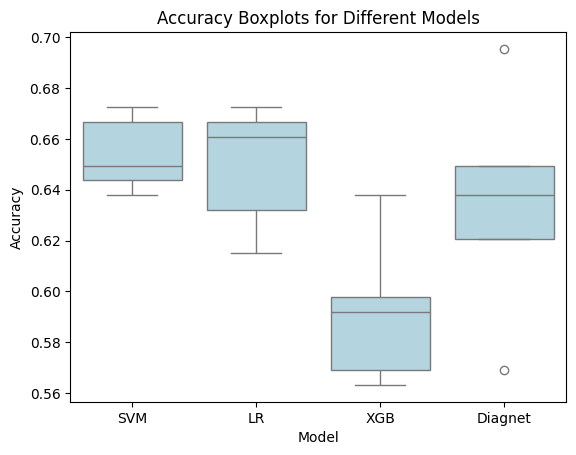

In [261]:
# Visualizing the accuracy for different split with boxplots

scores_svm_df['Model'] = 'SVM'
scores_lr_df['Model'] = 'LR'
scores_xgb_df['Model'] = 'XGB'
scores_diagnet_df['Model'] = 'Diagnet'

combined_df = pd.concat([scores_svm_df, scores_lr_df, scores_xgb_df, scores_diagnet_df])

sns.boxplot(x="Model", y="accuracy", data=combined_df, color="lightblue")

plt.title("Accuracy Boxplots for Different Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.savefig("./images/boxplots_accuracy.png")
plt.show()

In [240]:
# Since the SVM model is slightly better than the rest, we select it as the bes model
# We look at the parameters and metrics of its best estimator for each CV split
scores_svm_df[["accuracy", "roc_auc", "precision", "recall"]]

,accuracy,roc_auc,precision,recall
0,0.643678,0.638789,0.642606,0.567901
1,0.637931,0.633413,0.636789,0.567901
2,0.666667,0.660771,0.665577,0.587500
3,0.649425,0.643883,0.648088,0.575000
4,0.672414,0.677261,0.682166,0.737500


In [135]:
for i in range(5):
    print(scores_svm_df["best_params"].loc[i])

{'C': 100, 'degree': 3, 'gamma': 0.001, 'kernel': 'sigmoid'}
{'C': 10, 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf'}
{'C': 1000, 'degree': 3, 'gamma': 0.0001, 'kernel': 'rbf'}
{'C': 1, 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf'}
{'C': 0.1, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}


In [242]:
# We select the best hyperparameters according to the previous table and define the best model
best_model = SVC(random_state=42, kernel="rbf", C=1, gamma=0.01)

# We select the mask which corresponds to the best estimator
best_mask = masks[3] 

# Take the selected features for all the samples
X_selected = X[:,best_mask]

# Note that the mask which performed better did not correspond to the one with the largest number of features
print(f"Total number of samples: {X_selected.shape[0]}")
print(f"Number of features: {X_selected.shape[1]}")

Total number of samples: 870
Number of features: 200


In [100]:
# Train model with all samples and selected features
best_model.fit(X_selected, Y)

SVC(C=1, gamma=0.01, random_state=42)

In [101]:
train_score = best_model.score(X_selected, Y)
print(f"Train accuracy on the whole dataset: {train_score.round(4)}")

Train accuracy on the whole dataset: 0.692


#### Interpreting model

In [244]:
import nibabel as nib
from nilearn import plotting, image, datasets
import shap

In [ ]:
# We import the atlas which was originally used for computing the data
basc_197 = datasets.fetch_atlas_basc_multiscale_2015(version='sym', resolution="197")

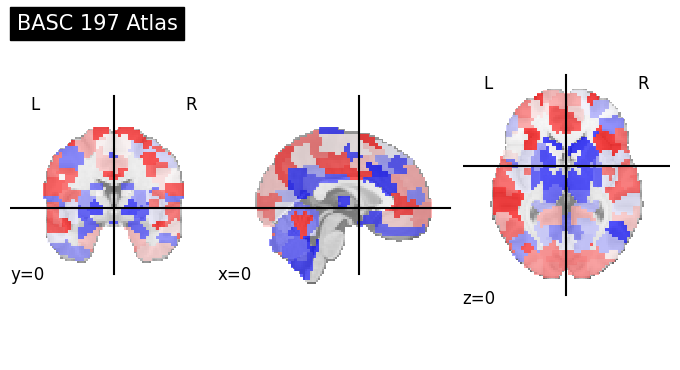

In [286]:
# Plotting the regions of interest of BASC197
plotting.plot_roi(
    basc_197["maps"], cmap=plotting.cm.bwr, title="BASC 197 Atlas", cut_coords=(0,0,0)
)

plt.savefig("./images/basc197.png")
plotting.show()

In [276]:
def features_names(n_rois, mask):
    """
    Given the number of ROIs, creates a list (labels_rois) naming each correlation between ROIs,
    and with a mask of the selected features, returns the names of the filtered correlations
    """

    booleans = np.tril(np.ones((n_rois, n_rois), dtype=bool))

    # Find the (i, j) indices for the given vector index
    indexes = np.column_stack(np.where(booleans))

    labels_rois = list()

    for i in range(X.shape[1]):
        name_rois = f"ROI_{indexes[i][0]+1}-ROI_{indexes[i][1]+1}"
        labels_rois.append(name_rois)

    filtered_roi_names = [name for name, keep in zip(labels_rois, mask) if keep]

    return filtered_roi_names, labels_rois

In [277]:
# Creating features' names (with the same mask used in the best model)
filtered_roi_names, labels_rois = features_names(n_rois=197, mask=masks[3])

In [125]:
# We take 200 samples to calculate SHAP values
samples = shap.sample(X_selected, nsamples=200) 

In [ ]:
# Create a SHAP explainer for the model
explainer = shap.KernelExplainer(best_model.predict, samples, feature_names=filtered_roi_names)

# Calculate SHAP values
shap_values = explainer(samples)

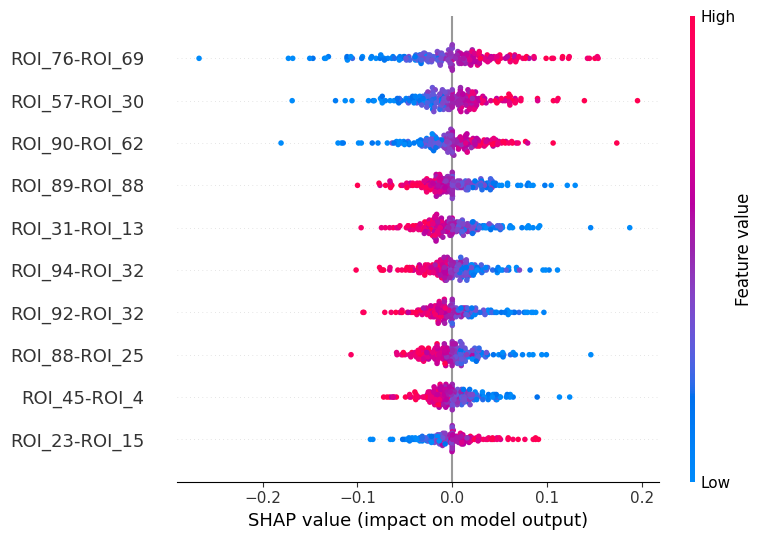

In [210]:
# Visualize top 10 most important SHAP values
shap.summary_plot(shap_values, samples, show=False, max_display=10)
plt.savefig("./images/shap_values_img.png")

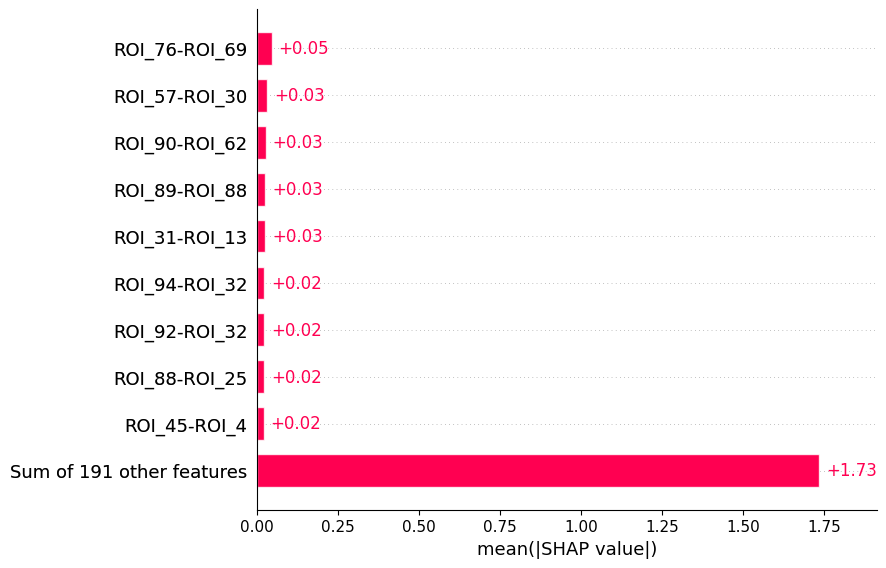

In [209]:
# Visualize the mean importance of each feature

plt.figure(figsize=(30, 30))
plt.tight_layout()
shap.plots.bar(shap_values, show=False)
plt.savefig('./images/shap_bar_plot.png', bbox_inches='tight')
plt.show()

In [245]:
# Coordinates for main ROIs
coords = plotting.find_parcellation_cut_coords(basc_197["maps"])

for roi in [76, 69, 57, 30, 90, 62]:
    print(f"Coordinates for ROI {roi}: {coords[roi-1]}")

Coordinates for ROI 76: [-7.         49.64285714 45.5       ]
Coordinates for ROI 69: [43.92358804 25.06312292 21.12292359]
Coordinates for ROI 57: [-45.91549296 -45.26760563  47.95774648]
Coordinates for ROI 30: [ -5.21311475 -44.62295082  22.8852459 ]
Coordinates for ROI 90: [-41.56179775 -34.15730337  44.74157303]
Coordinates for ROI 62: [-10.24342105 -44.67763158  36.42763158]


/tmp/ipykernel_1671/2427162428.py:15: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  roi_img = image.new_img_like(atlas_img, roi_mask.astype(int))


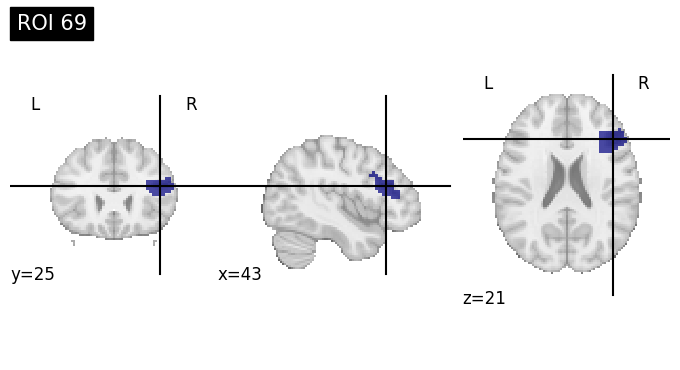

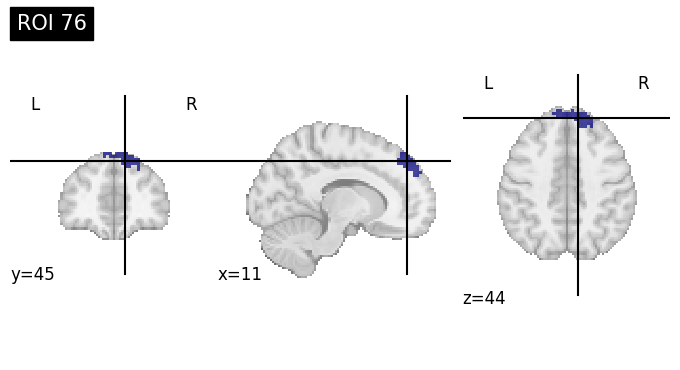

In [208]:
# Plotting the two ROIs which were most important for the model

atlas_img = nib.load(basc_197["maps"])
atlas_data = atlas_img.get_fdata()

for roi_index in [69,76]:
    
    roi_mask = np.zeros(atlas_data.shape, dtype=bool)
    roi_mask[atlas_data == roi_index] = True

    roi_img = image.new_img_like(atlas_img, roi_mask.astype(int))

    plotting.plot_roi(roi_img, draw_cross=True, title=f"ROI {roi_index}")
    plt.savefig(f"./images/roi_{roi_index}_img.png")
    plotting.show()


In [282]:
index_76_69 = labels_rois.index("ROI_76-ROI_69")
print(f"Correlation ROI 76 and 69 in controls: {X[Y==0][:, index_76_69].mean()}")
print(f"Correlation ROI 76 and 69 in ASD: {X[Y==1][:, index_76_69].mean()}")

Correlation ROI 76 and 69 in controls: 0.25960801946721274
Correlation ROI 76 and 69 in ASD: 0.2965760786921961
